# `mle-hyperopt`: Lightweight Hyperparameter Optimization
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: October 2021][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/mle-logging/blob/main/examples/getting_started.ipynb)

Validating a simulation across a large range of parameters or tuning the hyperparameters of a neural network is common practice for every computational scientist. There are many open source packages that implement individual algorithms, but many of them are either combersome to set up or follow different syntax. For my personal setup I wanted a simple API that allows me to generate batches of parameter configurations for various types of experiments and that comes with a set of handy utilities. These included the following: 

- **Simplicity and strategy diversity**: Most hyperparameter tools implement the newest population-based search/training algorithms and Bayesian Optimization variants, but often do not implement simple grid search. Yes, I know that [Bergstra and Bengio (2012)](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) showed that random search is more efficient, but my intuitive understanding as a scientiest is often more enhanced by semi-exhaustive evaluation.
- **Interactive search space refinement**: After a certain set of search iterations, it can make sense to refine your search space boundaries based on the top performing configurations. This way we can focus on a smaller range of promising configurations. This was for example done in [Schmidt et al. (2021)](https://arxiv.org/abs/2007.01547) and significantly improve computation efficient resource allocation. 
- **Exporting of configuration files**: Often times I want to submit training runs to some large compute cluster (slurm, etc.) and need to execute a downstream training routine that looks somewhat as follows: `python train.py --config_fname config.yaml`. In that case it is useful to have one script that executes calls to the cluster scheduler after having generated the configurations.
- **Storage and reloading of previous search logs**: I was astonished by how few libraries provide the simple utility of exporting and importing a previous search experiment for later continuation. E.g., in order to accomplish something similar in the FAIR's awesome [nevergrad](https://facebookresearch.github.io/nevergrad/) library, one has to write manual functionality that dumps the search log, reloads and supplies the previously stored results to a new search strategy instance.

And this was how the `mle-hyperopt` package was born. [***Note***: I by no means claim that this is something novel. Most likely you may your own substitute tool. But maybe you find a couple of the package's features useful. So hang in there 🤗] As of writing the package includes a set of diverse (e.g. single vs. multi-objective, model-free vs. model-based) search algorithms:

| Search Type           | Description | `search_config` |
|----------------------- | ----------- | --------------- |
|  `GridSearch`          |  Search over list of discrete values  | - |
|  `RandomSearch`        |  Random search over variable ranges         | `refine_after`, `refine_top_k` |
|  `SMBOSearch`          |  Sequential model-based optim.        | `base_estimator`, `acq_function`, `n_initial_points`
|  `CoordinateSearch`    |  Coordinate-wise optim. with defaults | `order`, `defaults`
|  `NevergradSearch`     |  Multi-objective [nevergrad](https://facebookresearch.github.io/nevergrad/) wrapper | `optimizer`, `budget_size`, `num_workers`

Each strategy implements a separate search space which one can sample from. The API follows the standard `ask`, `eval`, `tell` paradigm and in the remainder of this 'blog notebook' we will walk through the different features and use-cases. Let's start by implementing a small 'synthetic' helper function that evaluates the performance of a combination of 3 standard hyperparameters -- learning rate, batchsize and architecture:

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import mle_hyperopt
except:
    !pip install -q mle-hyperopt
    import mle_hyperopt

def fake_train(lrate, batch_size, arch):
    """Optimum: lrate=0.2, batch_size=4, arch='conv'."""
    f1 = ((lrate - 0.2) ** 2 + ((batch_size - 4)/4) ** 2
          + (0 if arch == "conv" else 0.2))
    return f1

## Basic API Usage: Grid Search Strategy

So let's imagine we simply want to search over a discretized space of training hyperparameters for our training surrogate. In order to do so need to define the search space. The `mle-hyperopt` package supports real-, integer- and categorically-valued parameters, whose ranges you specify via dictionaries. For reals and integers you have to specifiy the beginning and end of the range (`begin`/`end`) as well as a prior (e.g. uniform or log-uniform) or the number of bins to discretize (`prior`/`bins`).

In [2]:
from mle_hyperopt import GridSearch
# Instantiate grid search class
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "bins": 1}},
                      categorical={"arch": ["mlp", "cnn"]},
                      verbose=True)

We are now ready to ask our search strategy for a set of proposal candidates.

In [3]:
configs = strategy.ask(batch_size=2)
configs

[{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2}]

Next, we can evaluate our fake surrogate objective for the two proposal configurations and afterwards, we update the strategy with the collected data. Note that the API assumes that we are minimizing an objective. If you want to maximize simply multiply all objective values with minus 1.

In [4]:
# Simple ask - eval - tell API
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

### Saving and reloading previous search results

In [5]:
# Storing of results to .pkl
strategy.save("search_log.json")

# Reloading of results from .pkl
strategy.load("search_log.json")

{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1} was previously evaluated.
{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2} was previously evaluated.
Reloaded 0 previous search iterations.


In [6]:
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "bins": 1}},
                      categorical={"arch": ["mlp", "cnn"]},
                      reload_path="search_log.json")

Reloaded 2 previous search iterations.


### Inspecting the search results

In [7]:
# Have a looko at the internal log
strategy.log

[{'eval_id': 0,
  'params': {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1},
  'objective': 0.7725},
 {'eval_id': 1,
  'params': {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2},
  'objective': 0.7625}]

In [8]:
# Return flattened log as pandas dataframe
strategy.to_df()

,eval_id,objective,arch,batch_size,lrate
0,0,0.7725,mlp,1,0.1
1,1,0.7625,mlp,1,0.2


In [9]:
# Retrieving the best performing configuration
strategy.get_best()

(1, {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2}, 0.7625)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

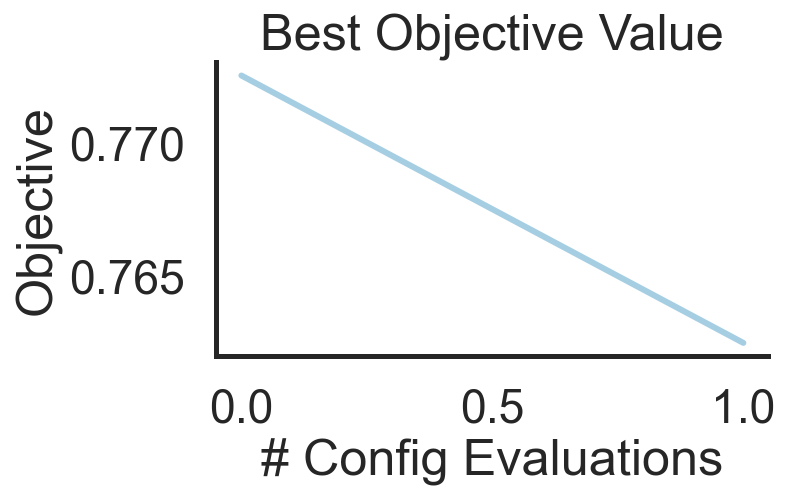

In [10]:
# Plot timeseries of best performing score over search iterations
strategy.plot_best()

In [11]:
# Print out ranking of best performers
strategy.print_ranking(top_k=1)

### Adding fixed parameters & storing configuration files

In [12]:
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "bins": 1}},
                      categorical={"arch": ["mlp", "cnn"]},
                      fixed_params={"momentum": 0.9})
strategy.ask(2, store=True)

([{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1, 'momentum': 0.9},
  {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2, 'momentum': 0.9}],
 ['eval_0.yaml', 'eval_1.yaml'])

## Single-Objective: Random Search

In [13]:
from mle_hyperopt import RandomSearch

strategy = RandomSearch(real={"lrate": {"begin": 0.1,
                                        "end": 0.5,
                                        "prior": "uniform"}},
                        integer={"batch_size": {"begin": 1,
                                                "end": 5,
                                                "prior": "log-uniform"}},
                        categorical={"arch": ["mlp", "cnn"]},
                        search_config={"refine_after": 5,
                                       "refine_top_k": 2},
                        seed_id=42,
                        verbose=True)

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

In [14]:
strategy.get_best(2)

(array([4, 3]),
 [{'arch': 'cnn', 'lrate': 0.123, 'batch_size': 3},
  {'arch': 'mlp', 'lrate': 0.34044600469728353, 'batch_size': 3}],
 [0.2684962362775649, 0.2822250802354294])

In [15]:
strategy.print_ranking(4)

In [16]:
strategy = RandomSearch(
        real={"lrate": {"begin": 0.1, "end": 0.5, "prior": "uniform"}},
        integer={"batch_size": {"begin": 1, "end": 5, "prior": "uniform"}},
        categorical={"arch": ["mlp", "cnn"]},
    )
configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.get_best(2)

(array([4, 3]),
 [{'arch': 'cnn', 'lrate': 0.12256463161084011, 'batch_size': 4},
  {'arch': 'cnn', 'lrate': 0.23348344445560876, 'batch_size': 3}],
 [0.20599623627756491, 0.26362114105261186])

## Single-Objective: Sequential Model-Based Optimization (SMBO)

In [17]:
from mle_hyperopt import SMBOSearch

strategy = SMBOSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "prior": "uniform"}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "prior": "uniform"}},
                      search_config={"base_estimator": "GP",
                                     "acq_function": "gp_hedge",
                                     "n_initial_points": 5},
                      fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

In [18]:
strategy.print_ranking(4)

## Multi-Objective: `nevergrad`

In [19]:
from mle_hyperopt import NevergradSearch

strategy = NevergradSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "prior": "uniform"}},
                           integer={"batch_size": {"begin": 1,
                                                   "end": 5,
                                                   "prior": "uniform"}},
                           search_config={"optimizer": "NGOpt",
                                          "budget_size": 100,
                                          "num_workers": 5},
                           fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.print_ranking(4)

In [20]:
def multi_fake_train(lrate, batch_size, arch):
    # optimal for learning_rate=0.2, batch_size=4, architecture="conv"
    f1 = ((lrate - 0.2) ** 2 + (batch_size - 4) ** 2
          + (0 if arch == "conv" else 10))
    # optimal for learning_rate=0.3, batch_size=2, architecture="mlp"
    f2 = ((lrate - 0.3) ** 2 + (batch_size - 2) ** 2
          + (0 if arch == "mlp" else 5))
    return f1, f2

In [21]:
strategy = NevergradSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "prior": "uniform"}},
                           integer={"batch_size": {"begin": 1,
                                                   "end": 5,
                                                   "prior": "uniform"}},
                           search_config={"optimizer": "NGOpt",
                                          "budget_size": 100,
                                          "num_workers": 5},
                           fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
values = [multi_fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.log

[{'eval_id': 0,
  'params': {'lrate': 0.2895155928359631, 'batch_size': 4},
  'objective': (10.008013041360774, 9.00010992279358)},
 {'eval_id': 1,
  'params': {'lrate': 0.27813231046267645, 'batch_size': 2},
  'objective': (14.006104657938236, 5.000478195845701)},
 {'eval_id': 2,
  'params': {'lrate': 0.16412518606830023, 'batch_size': 2},
  'objective': (14.001287002274633, 5.018461965060974)},
 {'eval_id': 3,
  'params': {'lrate': 0.3172378807360612, 'batch_size': 3},
  'objective': (11.013744720679483, 6.00029714453227)},
 {'eval_id': 4,
  'params': {'lrate': 0.28916633667720637, 'batch_size': 4},
  'objective': (10.007950635596433, 9.000117368260991)}]

In [22]:
strategy.print_ranking()

## Coordinate-Wise Search

Start scanning one parameter for fixed others and a fixed budget. Afterwards, fix the optimized parameter to best value and go over to next parameter. Repeat until all parameters are done. `search_config` specifies order of parameters and their default. Internally, we run a coordinate-wise grid search.

In [23]:
from mle_hyperopt import CoordinateSearch
strategy = CoordinateSearch(real={"lrate": {"begin": 0.1,
                                            "end": 0.5,
                                            "bins": 5}},
                            integer={"batch_size": {"begin": 1,
                                                    "end": 5,
                                                    "bins": 1}},
                            search_config={"order": ["lrate", "batch_size"],
                                           "defaults": {"lrate": 0.1,
                                                        "batch_size": 3}},
                            fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
configs

[{'batch_size': 3, 'lrate': 0.1, 'arch': 'cnn'},
 {'batch_size': 3, 'lrate': 0.2, 'arch': 'cnn'},
 {'batch_size': 3, 'lrate': 0.30000000000000004, 'arch': 'cnn'},
 {'batch_size': 3, 'lrate': 0.4, 'arch': 'cnn'},
 {'batch_size': 3, 'lrate': 0.5, 'arch': 'cnn'}]

In [24]:
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.log

[{'eval_id': 0,
  'params': {'batch_size': 3, 'lrate': 0.1},
  'objective': 0.2725},
 {'eval_id': 1,
  'params': {'batch_size': 3, 'lrate': 0.2},
  'objective': 0.2625},
 {'eval_id': 2,
  'params': {'batch_size': 3, 'lrate': 0.30000000000000004},
  'objective': 0.2725},
 {'eval_id': 3,
  'params': {'batch_size': 3, 'lrate': 0.4},
  'objective': 0.3025},
 {'eval_id': 4,
  'params': {'batch_size': 3, 'lrate': 0.5},
  'objective': 0.35250000000000004}]

In [25]:
configs = strategy.ask(4)
configs

[{'batch_size': 1, 'lrate': 0.2, 'arch': 'cnn'}]

In [26]:
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.log

IndexError: list index out of range

In [ ]:
strategy.all_evaluated_params

# `hyperopt` decorator - minimal search wrapper

Note: Assumes that function to evaluate directly consumes a configuration dictionary.

In [ ]:
from mle_hyperopt import hyperopt

@hyperopt(strategy_type="grid",
          num_search_iters=400,
          real={"x": {"begin": -0.5, "end": 0.5, "bins": 20},
                "y": {"begin": -0.5, "end": 0.5, "bins": 20}})
def circle_objective(config):
    distance = abs((config["x"] ** 2 + config["y"] ** 2))
    return distance

strategy = circle_objective()
len(strategy)

In [ ]:
strategy.plot_grid(params_to_plot=["x", "y"],
                   target_to_plot="objective",
                   plot_title="Circles for Life",
                   plot_subtitle="How beautiful can they be?",
                   xy_labels= ["x", "y"],
                   variable_name="Objective",
                   every_nth_tick=3)